In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

class MeanShiftSegmentation:
    def __init__(self, spatial_radius, range_radius, max_iterations=100, use_gaussian_weights=True, handle_outliers=True):
        """
        Initialize the MeanShiftSegmentation class.

        Parameters:
            spatial_radius (float): Spatial domain kernel radius.
            range_radius (float): Range domain kernel radius.
            max_iterations (int): Maximum number of iterations.
            use_gaussian_weights (bool): Whether to apply Gaussian weights.
            handle_outliers (bool): Whether to handle outliers.
        """
        self.spatial_radius = spatial_radius
        self.range_radius = range_radius
        self.max_iterations = max_iterations
        self.use_gaussian_weights = use_gaussian_weights
        self.handle_outliers = handle_outliers

    def preprocess_image(self):
        """
        Load and preprocess the input image.

        Parameters:
            image_path (str): Path to the input image.

        Returns:
            image (ndarray): Preprocessed RGB image.
        """
        
        image = cv2.GaussianBlur(self.input_image, (9, 9), 0)  # Apply Gaussian blur to reduce noise
        return image
    
    def read_image(self ,image_path):
        image = cv2.imread(image_path)
        self.input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

    def segment(self, image):
        """
        Apply Mean Shift segmentation to an image.

        Parameters:
            image (ndarray): Input RGB image.

        Returns:
            segmented_image (ndarray): Segmented RGB image.
        """
        # Convert the image to a 5D array: spatial (x, y) + color (R, G, B)
        height, width, channels = image.shape
        flat_image = np.zeros((height * width, 5), dtype=np.float32)

        for y in range(height):
            for x in range(width):
                flat_image[y * width + x] = np.array([x, y, *image[y, x]])

        # Build a KD-tree for fast neighbor lookup
        kd_tree = KDTree(flat_image[:, :2])

        # Mean Shift procedure
        for iteration in range(self.max_iterations):
            print(f"Iteration {iteration + 1}/{self.max_iterations}")
            for i in range(flat_image.shape[0]):
                point = flat_image[i]

                # Query neighbors within spatial radius
                spatial_neighbors = kd_tree.query_ball_point(point[:2], self.spatial_radius)

                distances = np.linalg.norm(flat_image[spatial_neighbors, :2] - point[:2], axis=1)
                color_distances = np.linalg.norm(flat_image[spatial_neighbors, 2:] - point[2:], axis=1)

                mask = (distances < self.spatial_radius) & (color_distances < self.range_radius)
                neighbors = np.array(spatial_neighbors)[mask]

                if self.use_gaussian_weights:
                    # Apply Gaussian weights
                    spatial_weights = np.exp(-(distances[mask]**2) / (2 * (self.spatial_radius**2)))
                    range_weights = np.exp(-(color_distances[mask]**2) / (2 * (self.range_radius**2)))
                    weights = spatial_weights * range_weights

                    weighted_sum = np.sum(flat_image[neighbors] * weights[:, np.newaxis], axis=0)
                    flat_image[i] = weighted_sum / np.sum(weights)
                else:
                    # Simple mean without weights
                    flat_image[i] = np.mean(flat_image[neighbors], axis=0)

        if self.handle_outliers:
            # Handle outliers
            mean_colors = np.mean(flat_image[:, 2:], axis=0)
            std_colors = np.std(flat_image[:, 2:], axis=0)
            threshold = 3 * std_colors  # Define outliers as points beyond 3 standard deviations
            for i in range(flat_image.shape[0]):
                color_distance = np.abs(flat_image[i, 2:] - mean_colors)
                if np.any(color_distance > threshold):
                    flat_image[i, 2:] = mean_colors  # Replace outliers with the mean color

        # Reshape the flat_image back to the original image shape
        segmented_image = flat_image[:, 2:].reshape((height, width, channels)).astype(np.uint8)
        return segmented_image

    def display_results(self, original_image, segmented_image , process='Segmented Image'):
        """
        Display the original and segmented images.

        Parameters:
            original_image (ndarray): Original RGB image.
            segmented_image (ndarray): Segmented RGB image.
        """
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(original_image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(process )
        plt.imshow(segmented_image)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def save_image(self, image, output_path):
        """
        Save the segmented image.

        Parameters:
            image (ndarray): Segmented RGB image.
            output_path (str): Path to save the image.
        """
        cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))




In [6]:

spatial_radius = 10
range_radius = 25
max_iterations = 5

# Initialize the MeanShiftSegmentation class
mean_shift = MeanShiftSegmentation(spatial_radius, range_radius, max_iterations, use_gaussian_weights=False, handle_outliers=False)
mean_shift.read_image('c.jpg')


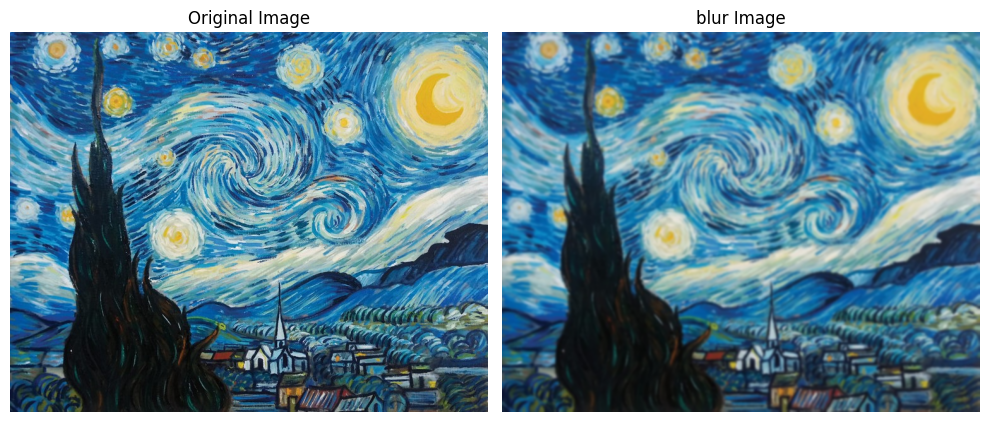

In [7]:
# Preprocess the input image
input_blur_image = mean_shift.preprocess_image()
mean_shift.display_results(mean_shift.input_image  , input_blur_image,'blur Image')

In [25]:
# Apply Mean Shift segmentation
segmented_image = mean_shift.segment(input_blur_image)


Iteration 1/7
Iteration 2/7
Iteration 3/7
Iteration 4/7
Iteration 5/7
Iteration 6/7
Iteration 7/7


c:\Users\akgh1\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\akgh1\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\akgh1\AppData\Local\Temp\ipykernel_1324\1392612131.py:100: RuntimeWarning: invalid value encountered in cast
  segmented_image = flat_image[:, 2:].reshape((height, width, channels)).astype(np.uint8)


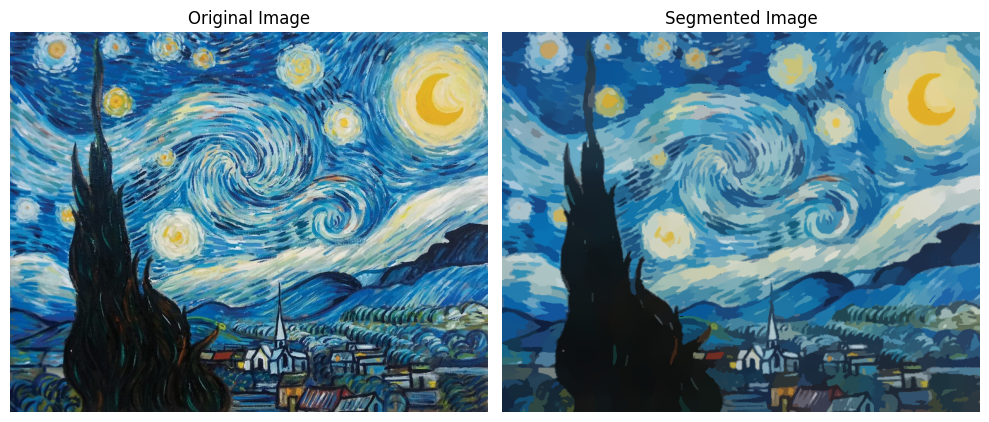

In [198]:
# Display results
mean_shift.display_results(mean_shift.input_image, segmented_image)

In [ ]:

# Save the segmented image
mean_shift.save_image(segmented_image, 'segmented_image.jpg')